In [65]:
import codecs
import os
import stanza
import pickle

In [66]:
def load_data():
    filepath = './data/'
    L='spa-temp.spa-eng'
    with codecs.open(os.path.join(filepath, L), 'r', 'utf-8') as inp:
        data = inp.read().split("\n")
    L='temp-reverse.align'
    with codecs.open(os.path.join(filepath, L), 'r', 'utf-8') as inp:
        alignment = inp.read().split("\n")

    es_data = [line.split(' |||')[0] for line in data]
    en_data = [line.split('||| ')[1] if len(line.split('|||'))>1 else '' for line in data]
    return es_data, en_data, alignment

def save_data(eng_tokens):
    with open('./data/eng_lemma_small.pickle', 'wb') as writer:
        pickle.dump(eng_tokens, writer)

def extract_info(en_text):
    doc_len = len(en_text)
    nlp = stanza.Pipeline(lang='en', tokenize_pretokenized=True, 
                          tokenize_no_ssplit = True, processors='tokenize,mwt,pos,lemma')
    curr_len = 0
    n_l = 1000000
    eng_tokens = []
    i=0
    while curr_len<doc_len:
        prev_len = curr_len
        curr_len = curr_len+n_l
        if curr_len<=doc_len-2 and en_text[curr_len]!='\n' and en_text[curr_len+1]!='\n':
            while curr_len<=doc_len-2 and en_text[curr_len]!='\n' and en_text[curr_len+1]!='\n':
                curr_len=curr_len+1
            curr_len=curr_len+1
        if curr_len>doc_len:
            eng_doc = nlp(en_text[prev_len:doc_len])
        else:
            eng_doc = nlp(en_text[prev_len:curr_len])
        eng_doc1 = [["{}||{}||{}||{}||{}".format(word.text, word.lemma, word.upos, word.xpos, word.feats)
                    for i,word in enumerate(sent.words)] for sent in eng_doc.sentences]
        eng_tokens.extend(eng_doc1)
        print(prev_len, curr_len)
    print("completed")
    return eng_tokens

def load_pickle():
    with open('./data/eng_lemma_small.pickle', 'rb') as writer:
        eng_tokens  = pickle.load(writer)
        return eng_tokens

### create_lemmatized_data.py

In [67]:
import codecs
import os
import stanza
import logging
import multiprocessing
from functools import partial
from log import logger
# logger = logging.getLogger('MyLogger')
logger.setLevel(logging.DEBUG)

# !cat data/en.txt | sacremoses -l en -j 4 \
#     normalize -c tokenize -a truecase -a -m data/en.truemodel \
#     > data/en.txt.norm.tok.true

# !cat data/es.txt | sacremoses -l es -j 4 \
#     normalize -c tokenize -a truecase -a -m data/es.truemodel \
#     > data/es.txt.norm.tok.true

def file_read(path, filename, formats):
    if formats=='codecs':
        with codecs.open(os.path.join(path, filename), 'r', 'utf-8') as inp:
            data = inp.read().split("\n")
        return data

def file_write(path, filename, formats, data):
    if formats=='codecs':
        with codecs.open(os.path.join(path, filename), 'w') as writer:
            writer.write(data)

def split_translation(path, filename):
    with codecs.open(os.path.join(path, filename), 'r', 'utf-8') as inp:
        data = inp.read().split("\n")
    es_data = [line.split(' |||')[0] for line in data]
    en_data = [line.split('||| ')[1] if len(line.split('|||'))>1 else False for line in data]
    return en_data, es_data

# en_data, es_data = split_translation('./data/Europarl3/spa_eng/', 'Europarl3.orig.spa-eng')

def morph_info(start_end,dic,task,nlp):
    sp_doc = nlp(dic[start_end[0]:start_end[1]])
    if task=='lemma':
            eng_doc1 = [" ".join([word.lemma for i,word in enumerate(sent.words)]) for sent in sp_doc.sentences]
    if task=='morph':
        eng_doc1 = [["{}||{}||{}||{}||{}".format(word.text, word.lemma, word.upos, word.xpos, word.feats)
                                for i,word in enumerate(sent.words)] for sent in sp_doc.sentences]
    logger.info("length: {} done".format(start_end))
    return eng_doc1

def lemma_morph_data(en_text,lang,task):
    logger.debug("debug message")
    doc_len = len(en_text)
    nlp = stanza.Pipeline(lang=lang, tokenize_pretokenized=False, tokenize_no_ssplit = True, 
                          processors='tokenize,mwt,pos,lemma')
    curr_len = 0
    n_l = 100000
#     n_l = 500
    eng_tokens = []
    start_end = []
    i=0
    while curr_len<doc_len:
        prev_len = curr_len
        curr_len = curr_len+n_l
        if curr_len<=doc_len-2 and en_text[curr_len]!='\n' and en_text[curr_len+1]!='\n':
            while curr_len<=doc_len-2 and en_text[curr_len]!='\n' and en_text[curr_len+1]!='\n':
                curr_len=curr_len+1
            curr_len=curr_len+1
        if curr_len>doc_len:
            start_end.append((prev_len,doc_len))
#             eng_doc = nlp(en_text[prev_len:doc_len])
        else:
            start_end.append((prev_len,curr_len))
#             eng_doc = nlp(en_text[prev_len:curr_len])
#         if task=='lemma':
#             eng_doc1 = [" ".join([word.lemma for i,word in enumerate(sent.words)]) for sent in eng_doc.sentences]
#         elif task == 'morph':
#             eng_doc1 = [["{}||{}||{}||{}||{}".format(word.text, word.lemma, word.upos, word.xpos, word.feats)
#                         for i,word in enumerate(sent.words)] for sent in eng_doc.sentences]
        logger.debug("currently processing: {}".format(curr_len))
    logger.info("length list: {}".format(start_end))
    p = multiprocessing.Pool(processes = multiprocessing.cpu_count()-1)
    sent_x=partial(morph_info, dic=en_text, task = 'morph', nlp=nlp)
    eng_tokens = p.map(sent_x, start_end)
    p.close()
    p.join()
#         logger.debug("currently processing: {}".format(curr_len))
    flattens = [tok2 for tok1 in eng_tokens for tok2 in tok1]
    return flattens

def join_splitted(esL, enL, filepath = './data/'):      
    es_tok_true = file_read(filepath, esL, 'codecs')
    en_tok_true = file_read(filepath, enL, 'codecs')  
    if (len(es_tok_true)!=len(en_tok_true)):
        logger.debug('spa:{} eng:{} lenghts are not equal'.format(len(es_tok_true),len(en_tok_true)))
        return None
    logger.debug('spa:{} eng:{} lenghts are equal'.format(len(es_tok_true),len(en_tok_true)))
    es_en_tok_true = "\n".join("{0} ||| {1}".format(x,y) for x,y in zip(es_tok_true,en_tok_true))
    return es_en_tok_true

# load_save_tokenize('es.txt.norm.tok.true', 'en.txt.norm.tok.true', 'tokenized')

def load_lemmatize(lang): 
    filepath = './data/'    
    L=lang+'.txt.norm.tok.true'
    tok_true = file_read(filepath, L, 'codecs')
    data = '\n\n'.join(tok_true)
    data_lemma = lemma_morph_data(data, lang, 'lemma')
    data_lemma = "\n".join(data_lemma)
    return data_lemma

if __name__ == "__main__":
    filepath = './data/'
#     esL = load_lemmatize('es')
#     file_write(filepath, 'es_tok_lemma.txt', 'codecs', esL)
#     enL = load_lemmatize('en')
#     file_write(filepath, 'en_tok_lemma.txt', 'codecs', enL)
##### save tokenized parallel data
#     es_en_joined_tokenized = join_splitted('es.txt.norm.tok.true', 'en.txt.norm.tok.true') 
#     file_write(filepath,'spa-eng-{}.spa-eng'.format('tokenized'),'codecs', es_en_joined_tokenized)
##### save lemmatized parallel data
#     es_en_joined_lemmatized = join_splitted('es_tok_lemma.txt', 'en_tok_lemma.txt') 
#     file_write(filepath,'spa-eng-{}.spa-eng'.format('lemmatized'),'codecs', es_en_joined_lemmatized)
##### constract and save en morphological data
#     en_tok_true = file_read(filepath, 'en.txt.norm.tok.true', 'codecs')
#     en_tok_true = '\n\n'.join(en_tok_true)
#     en_morph_lemma = lemma_morph_data(en_tok_true, 'en', 'morph')
# #     print(en_morph_lemma)
#     file_write(filepath,'en_morph_lemma.txt','codecs', str(en_morph_lemma))

### find_error.py

In [ ]:
import codecs
import os
filepath = './data/'
L='es.txt.norm.tok.true'
with codecs.open(os.path.join(filepath, L), 'r', 'utf-8') as inp:
    es_tok_true = inp.read().split("\n")

L='es_tok_lemma.txt'
with codecs.open(os.path.join(filepath, L), 'r', 'utf-8') as inp:
    es_tok_lemma = inp.read().split("\n")

print(len(es_tok_true),len(es_tok_lemma))
for i, tok in enumerate(es_tok_true):
#     print(abs(len(tok)-len(es_tok_lemma[i])))
    if len(tok)>10 and len(es_tok_lemma[i])<3:
        print(i)

### Make alignment

In [55]:
# # ##### raw prallel data
# ! ../fast_align/build/fast_align -i ./data/Europarl3.orig.spa-eng -d -o -v -r > ./data/spa-eng-reverse.align 2> ./data/fast_align-raw.log.txt
# # ##### tokenized prallel data
# ! ../fast_align/build/fast_align -i ./data/spa-eng-tokenized.spa-eng -d -o -v -r > ./data/spa-eng-reverse-tokenized.align 2> ./data/fast_align-tokenized.log.txt
# # ##### lemmatized prallel data
# ! ../fast_align/build/fast_align -i ./data/spa-eng-lemmatized.spa-eng -d -o -v -r > ./data/spa-eng-reverse-lemmatized.align 2> ./data/fast_align-lemmatized.log.txt

### alignment_iterate.py

In [68]:
from log import logger
from ast import literal_eval 
import pandas as pd
import numpy as np
import warnings
import pickle
import sys
import itertools
from itertools import groupby
from operator import itemgetter
from collections import defaultdict
from collections import Counter
from boltons.iterutils import remap
if not sys.warnoptions:
    warnings.simplefilter("ignore")
eps = '\u0395'

import logging
from log import logger
# logger = logging.getLogger('MyLogger')
logger.setLevel(logging.INFO)
  
def convert(lst): 
    return literal_eval(lst) 

def do_alignment(en_all, es_all, alignment):
    en_form_lemma = {}
    en_lemma_count = defaultdict(int)
    en_es_align = {}
    es_en_align = {}
    es_upos = {}
    es_xpos = {}
    es_feats = {}
    pos_allowed = ['NOUN','VERB']
    for i, align in enumerate(alignment):
        try:
            if len(align)>1:
                for al in align.split(" "):
                    es,en = al.split('-')
                    es,en =  int(es), int(en)
                    try:
                        if len(en_all[i][en].split('||'))==5:
                            en_form, en_lemma, en_upos, en_xpos, en_feats = en_all[i][en].split('||')
                            es_word = es_all[i][es]
                            if en_upos in pos_allowed:
                                c=en_es_align.setdefault(en_lemma,{})
                                c[es_word]=c.setdefault(es_word,0)+1
                                
                                c=es_en_align.setdefault(es_word,{})
                                c[en_lemma]=c.setdefault(en_lemma,0)+1
                                
                                c=es_upos.setdefault(es_word,{})
                                c[en_upos]=c.setdefault(en_upos,0)+1
                                
                                c=es_xpos.setdefault(es_word,{})
                                c[en_xpos]=c.setdefault(en_xpos,0)+1
                                
                                c=es_feats.setdefault(es_word,{})
                                c[en_feats]=c.setdefault(en_feats,0)+1
                                
                                en_form_lemma[en_form] = en_lemma
                                en_lemma_count[en_lemma] = en_lemma_count[en_lemma]+1
                    except IndexError:
                        logger.info("Missalignment: length of en_all[{}]:{}, en:{}".format(i,len(en_all[i]),en))
#                         logger.info("en_all[{}]:{}".format(i,en_all[i][en]))
        except ValueError:
            logger.info("Value error: en_all[{}]:{}".format(i,en_all[i]))
    logger.info("do alignment done")
    return en_es_align, es_en_align, es_upos, es_xpos, es_feats, en_form_lemma, en_lemma_count

def construct_table(es_en_align, es_lemma, es_upos, es_xpos, es_feats):
    es_property = [['es_word','en_lemma','es_lemma','upos','xpos','feats']]
    for es,ens in es_en_align.items():
        #find en
        opt_en = max(ens.items(), key=lambda k: k[1])
        #find lemma
        opt_lemma = max(es_lemma[es].items(), key=lambda k: k[1])
        #find upos
        opt_upos =  max(es_upos[es].items(), key=lambda k: k[1])
        #find xpos
        opt_xpos =  max(es_xpos[es].items(), key=lambda k: k[1])
        #find feats
        opt_feats =  max(es_feats[es].items(), key=lambda k: k[1])
        es_property.append([es, opt_en[0], opt_lemma[0], opt_upos[0], opt_xpos[0], opt_feats[0]])
    es_property_df = pd.DataFrame.from_records(es_property[1:],columns=es_property[0])
    logger.info("construct table done")
    return es_property_df

def common(l,m):
    l_o = l
    if not l: return []
    if m is not None: l.sort()
    lm = list(filter(lambda x: len(x)>=m, l))
    left = set(l).difference(set(lm))
    lemma_words = [(os.path.commonprefix(g),list(set(g))) if len(os.path.commonprefix(g))>4 
          else (min(filter(None, g), key=len),list(set(g)))
            for g in [list(g) for k, g in groupby(lm, itemgetter(0,1,2))]]
    lw_tuples = []
    for lemma, words in lemma_words:
        lw_tuples.extend(list(zip(itertools.repeat(lemma),words)))
    others = list(zip(left,left))
    if len(others)!=0:
        lw_tuples.extend(others)
#     print(l_o)
    lw_tuples.sort(key=lambda x: l_o.index(x[1]))
    return lw_tuples

def lemma_cluster_2nd(es_property):
    grouped = es_property.groupby(['en_lemma'])
    for name,group in grouped:
        lemma_l = list(group['es_lemma'].values)
        nl,ol = zip(*common(lemma_l,4))
        c = [nl[list(ol).index(a)] for a in lemma_l]
        es_property['es_lemma'] = es_property['es_lemma'].replace(lemma_l, c)
    logger.info("lemma clustering 2nd done")
    return es_property

def lemma_filter_cluster(en_lemma_count, en_es_align, es_en_align, freq_to_discard):
    en_lemma_counter = Counter(en_lemma_count)
    #50 most frequent data
    en_lemma_50 = [a for a,b in en_lemma_counter.most_common(len(en_lemma_count)//2) if len(a)>2 and a.isalpha()]
    #cluster in es lemma
    lemma_cluster=[]
    for key, value in en_es_align.items():
        lemma_cluster.extend(common(list(value.keys()),4))
    logger.info("lemma clustering done")
    #es lemma-word dict
    es_lemma = {}
    for k, v in lemma_cluster:
        c=es_lemma.setdefault(v,{})
        c[k]=c.setdefault(k,0)+1
    #discard words based on freq_to_discard
    en_es_align = remap(en_es_align, lambda p, k, v: v not in freq_to_discard and v!={})
    es_en_align = remap(es_en_align, lambda p, k, v: v not in freq_to_discard and v!={})
    logger.info("filter data done")
    return en_lemma_50, es_lemma, en_es_align, es_en_align

def feats_transform(df):
    feats =  df.feats.unique()
    n_ds = np.zeros(shape=(df.shape[0],df.shape[1]+len(feats)-1))
    gdf = pd.DataFrame(df.groupby(['en_lemma','es_lemma']).aggregate('first')).reset_index()
    pdf = pd.pivot_table(df, values='es_word', index=['en_lemma','es_lemma'],
                    columns=['feats'], aggfunc='first', fill_value=0).reset_index()
    gpdf = pd.merge(gdf, pdf[pdf.columns[2:]], left_index=True, right_index=True,how='inner')
    logger.info("feature transform done")
    return gpdf

def do_iteration(dst_all, src_all, alignment, freq_order_reduce):
###################
# ##  load alignment data
#     alignment = file_read(filepath, alignfile, 'codecs')
#     logger.info("alignment length:{}".format(len(alignment)))
#     #load english and spanish parallel data
#     en_data, es_data = split_translation(filepath, parallelfile)
#     logger.info("es data length:{} en data length: {}".format(len(en_data),len(es_data)))
#    #load english morphological data
#     with codecs.open(os.path.join(filepath, en_morph_file), 'r', 'utf-8') as inp:
#             en_morph_lemma = inp.read()
#     en_all = convert(en_morph_lemma)
#     logger.info("en morphological data length:{}".format(len(en_all)))
####################
    
#    #create data dictionaries
#     es_all = [line.split(" ") for line in es_data]
#     logger.info("es_all:{} en_all:{} alignment:{}".format(len(es_all),len(en_all),len(alignment)))
    en_es_align, es_en_align, es_upos, es_xpos, es_feats, en_form_lemma, en_lemma_count = do_alignment(src_all, 
                                                                                                   dst_all, 
                                                                                                   alignment)
    #lemma filter
#     freq_order_reduce = [0,1]
    en_lemma_50, es_lemma, en_es_align, es_en_align = lemma_filter_cluster(en_lemma_count, 
                                                                        en_es_align, 
                                                                        es_en_align,freq_order_reduce)

######################
    #construct table
    es_property = construct_table(es_en_align, es_lemma, es_upos, es_xpos, es_feats)
    logger.info("es prperty dataframe shape:{}".format(es_property.shape))
    #2nd order lemma cluster
    es_property = lemma_cluster_2nd(es_property)
    es_property = es_property[es_property['en_lemma'].isin(en_lemma_50)]
    es_nouns = es_property.loc[es_property['upos']=='NOUN'].copy()
    logger.info("es_nouns dataframe shape:{}".format(es_nouns.shape))
    es_nouns_t = feats_transform(es_nouns)
    logger.info("es_nouns_t dataframe shape:{}".format(es_nouns_t.shape))
    es_verbs = es_property.loc[es_property['upos']=='VERB'].copy()
    logger.info("es_verbs dataframe shape:{}".format(es_verbs.shape))
    es_verbs_t = feats_transform(es_verbs)
    logger.info("es_verbs_t dataframe shape:{}".format(es_verbs_t.shape))
    es_form_lemma = dict(zip(es_property['es_word'].values,es_property['es_lemma'].values))
    en_form_lemma_f = dict((k, v) for k,v in en_form_lemma.items() if v in en_lemma_50)
    return es_property, es_nouns_t, es_verbs_t, es_form_lemma, en_form_lemma_f, en_es_align, es_en_align
#     filepath = './data/'
#     with open(os.path.join(filepath,'es_df.pickle'),'wb') as inp:
#         pickle.dump(es_property, inp)
        
# if __name__ == "__main__":
#     it = 'it_3'
#     filepath = './data/'
#     alignfile =  'spa-eng-reverse-{}.align'.format(it)#'temp-reverse.align'#'spa-eng-reverse.align'
#     parallelfile = 'spa-eng-tokenized.spa-eng'#'spa-temp.spa-eng'#'spa-eng.spa-eng'
#     en_morph_file = 'en_morph_lemma.txt'#'en_morph_lemma_small.txt'#'en_morph_lemma.txt'
#     es_property_file = 'es_df-.pickle'.format(it)
#     freq_order_reduce = [0,1,2]
#     logger.info("Iteration: {}".format(it))
# ##  load alignment data
#     alignment = file_read(filepath, alignfile, 'codecs')
#     if alignment[len(alignment)-1]=='\n' or alignment[len(alignment)-1]=='':
#         alignment = alignment[:-1]
#     logger.info("alignment length:{}".format(len(alignment)))
#     #load english and spanish parallel data
#     en_data, es_data = split_translation(filepath, parallelfile)
#     logger.info("es data length:{} en data length: {}".format(len(en_data),len(es_data)))
#     es_all = [line.split(" ") for line in es_data]
#     logger.info("es_all:{} en_all:{} alignment:{}".format(len(es_all),len(en_all),len(alignment)))
# ##  load english morphological data
# #     with codecs.open(os.path.join(filepath, en_morph_file), 'r', 'utf-8') as inp:
# #             en_morph_lemma = inp.read()
# #     en_all = convert(en_morph_lemma)
#     logger.info("en morphological data length:{}".format(len(en_all)))
#     es_property, es_nouns_t, es_verbs_t, es_form_lemma, en_form_lemma = do_iteration()
#     with open(os.path.join(filepath,es_property_file),'wb') as inp:
#         pickle.dump(es_property, inp)

### Replace words with constructed lemma in files

In [254]:
%%time
import re
import codecs
import os
import multiprocessing
from functools import partial
from log import logger

def replace_all(text,dic):
    new_text=''
    words = text.split(' ')
    for  i,word in enumerate(words):
        if word in dic.keys():
            word_rep = dic[word]
            words[i] = word_rep
    words = ' '.join(words)
    return words

if __name__ == "__main__":
    it='it_4'
    filepath = './data/'
    tok_file='en.txt.norm.tok.true'    
    with codecs.open(os.path.join(filepath, tok_file), 'r', 'utf-8') as inp:
        tok_data = inp.read().split('\n')
    p = multiprocessing.Pool(processes = multiprocessing.cpu_count()-1)
    replace_x=partial(replace_all, dic=en_form_lemma)
    processed_text= p.map(replace_x, tok_data)         
    p.close()
    p.join()
    processed_en = '\n'.join(processed_text)
    file_write(filepath,'en_tok_lemma-{}.txt'.format(it),'codecs', processed_en)
    
    tok_file='es.txt.norm.tok.true'    
    with codecs.open(os.path.join(filepath, tok_file), 'r', 'utf-8') as inp:
        tok_data = inp.read().split('\n')
    p = multiprocessing.Pool(processes = multiprocessing.cpu_count()-1)
    replace_x=partial(replace_all, dic=es_form_lemma)
    processed_text= p.map(replace_x, tok_data)         
    p.close()
    p.join()
    processed_es = '\n'.join(processed_text)
    file_write(filepath,'es_tok_lemma-{}.txt'.format(it),'codecs', processed_es)
    
##### save lemmatized parallel data
    es_en_joined_lemmatized_it = join_splitted('es_tok_lemma-{}.txt'.format(it), 'en_tok_lemma-{}.txt'.format(it))
    file_write(filepath,'spa-eng-{}.spa-eng'.format(it),'codecs', es_en_joined_lemmatized_it)


CPU times: user 11.8 s, sys: 13.8 s, total: 25.6 s
Wall time: 35.1 s


In [255]:
! ../fast_align/build/fast_align -i ./data/spa-eng-it_4.spa-eng -d -o -v -r > ./data/spa-eng-reverse-it_4.align 2> ./data/fast_align-it_4.log.txt

### en side tokenized, es side with constructed lemma

In [207]:
##### save lemmatized spa parallel data and tokenized english data
es_en_joined_lemmatized_it1 = join_splitted('es_tok_lemma-it_1.txt', 'en.txt.norm.tok.true')
file_write(filepath,'spa-eng-{}.spa-eng'.format('it_1-en_tok-es_lemma'),'codecs', es_en_joined_lemmatized_it1)

! ../fast_align/build/fast_align -i ./data/spa-eng-it_1-en_tok-es_lemma.spa-eng -d -o -v -r > ./data/spa-eng-reverse-it_1-en_tok-es_lemma.align 2> ./data/fast_align-it_1-en_tok-es_lemma.log.txt

### en side tokenized, es side lemmatized

In [217]:
##### save lemmatized spa parallel data and tokenized english data
es_en_joined_lemmatized_it1 = join_splitted('es.txt.norm.tok.true', 'en_tok_lemma.txt')
file_write(filepath,'spa-eng-{}.spa-eng'.format('en_lemma-es_tok'),'codecs', es_en_joined_lemmatized_it1)

! ../fast_align/build/fast_align -i ./data/spa-eng-en_lemma-es_tok.spa-eng -d -o -v -r > ./data/spa-eng-reverse-en_lemma-es_tok.align 2> ./data/fast_align-en_lemma-es_tok.log.txt

### Plot results

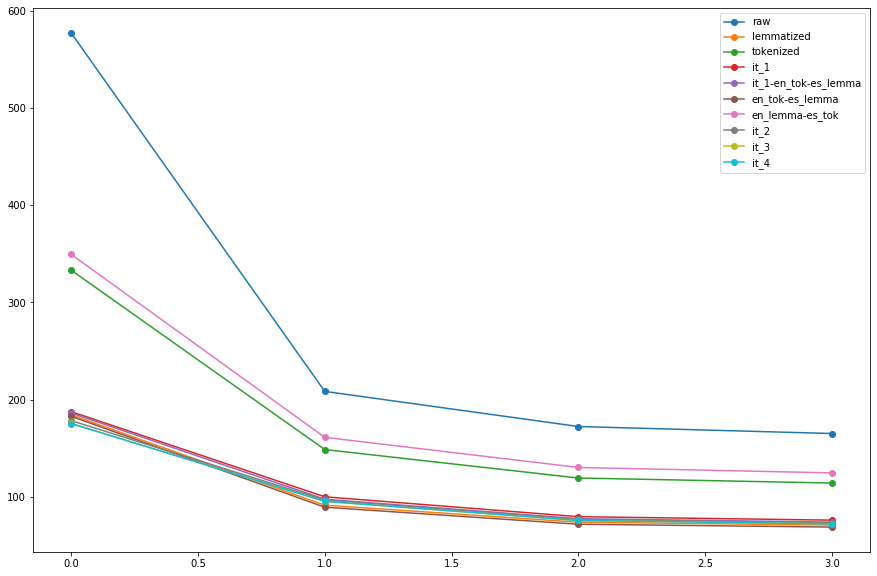

In [256]:
import matplotlib.pyplot as plt
import codecs
import os


def calc_result(filepath, filename):
    with codecs.open(os.path.join(filepath,filename),'r') as inp:
        log_data = inp.read().split('\n')
    result={}
    for i,data in enumerate(log_data):
        d_sp = data.split(' ')
        l_d = len(d_sp)
        if d_sp[0]=='ITERATION':
            it = int(d_sp[1])
            result[it]={}
        if 'log_e' in d_sp:
            result[it]['log_e'] = float(d_sp[4])
        if 'log_2' in d_sp:
            result[it]['log_2'] = float(d_sp[4])
        if 'entropy:' in d_sp:
            result[it]['entropy'] = float(d_sp[7])
        if 'perplexity:' in d_sp:
            result[it]['perplexity'] = float(d_sp[9])
    return result

if __name__ == "__main__":
    log_files=['raw','lemmatized','tokenized','it_1',
               'it_1-en_tok-es_lemma','en_tok-es_lemma', 'en_lemma-es_tok','it_2','it_3','it_4']
    filepath = './data/'
    results = {}
    for log_name in log_files:
        results[log_name] = calc_result(filepath,'fast_align-{}.log.txt'.format(log_name))
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)

    for name, result in results.items():
        perplex=[]
        for i,metric in result.items():
            if i>1:
                perplex.append(metric['perplexity'])
        ax.plot(perplex,marker='o')
    ax.legend(results.keys())
    plt.show()

In [266]:
for name, result in results.items():
    perplex=[]
    for i,metric in result.items():
        if i>1:
            print("data: {}, iteration: {}, perplexity: {}".format(name, i, metric['perplexity']))
    print()

data: raw, iteration: 2, perplexity: 577.455
data: raw, iteration: 3, perplexity: 208.408
data: raw, iteration: 4, perplexity: 172.255
data: raw, iteration: 5, perplexity: 165.053

data: lemmatized, iteration: 2, perplexity: 184.372
data: lemmatized, iteration: 3, perplexity: 91.2622
data: lemmatized, iteration: 4, perplexity: 73.7685
data: lemmatized, iteration: 5, perplexity: 70.7652

data: tokenized, iteration: 2, perplexity: 333.233
data: tokenized, iteration: 3, perplexity: 148.545
data: tokenized, iteration: 4, perplexity: 119.249
data: tokenized, iteration: 5, perplexity: 114.075

data: it_1, iteration: 2, perplexity: 187.6
data: it_1, iteration: 3, perplexity: 99.906
data: it_1, iteration: 4, perplexity: 79.4541
data: it_1, iteration: 5, perplexity: 75.877

data: it_1-en_tok-es_lemma, iteration: 2, perplexity: 186.174
data: it_1-en_tok-es_lemma, iteration: 3, perplexity: 97.4253
data: it_1-en_tok-es_lemma, iteration: 4, perplexity: 77.3769
data: it_1-en_tok-es_lemma, iteration:

### corpus to sent to line

In [17]:
import os
from log import logger
import multiprocessing
from functools import partial


def record_corpus(corpus, vocabSize=250):

    corpus_tokens = [] # corpus
    corpus_types = {}
    gold_sents = []
    sents = []
    with open(corpus) as open_corpus:
        for line in open_corpus:
            gold_sent = []
            sent = []
            for word in line.split():
                wf = word
                lemma, cell_unfactored = None, None
                word = word.split('|||')
                if len(word) > 2:
                    lemma, cell_unfactored = word[-2:]
                    lemma = '_'.join(lemma.split('_')[:-1])
                    wf = '|||'.join(word[:-2])
                # Record all corpus forms
                corpus_tokens.append(wf)

    return ' '.join(corpus_tokens)

def sent_splits(start_end,dic,nlp):
    sp_doc = nlp(dic[start_end[0]:start_end[1]])
    sents = []
    for sent in sp_doc.sents:
        sents.append(sent.text) 
    logger.info("length: {} done".format(start_end))
    return sents

import spacy


def corp_to_sent(texts):
    doc_len = len(texts)
    nlp = spacy.load('en_core_web_sm')
    curr_len = 0
    n_l = 500000
    sents = []
    i=0
    start_end = []
    while curr_len<doc_len:
        prev_len = curr_len
        curr_len = curr_len+n_l
        if curr_len<=doc_len-2 and texts[curr_len]!='.' and texts[curr_len+1]!=' ':
            while curr_len<=doc_len-2 and texts[curr_len]!='.' and texts[curr_len+1]!=' ':
                curr_len=curr_len+1
            curr_len=curr_len+1
        if curr_len>doc_len:
            start_end.append((prev_len,doc_len))
#             sp_doc = nlp(texts[prev_len:doc_len])
        else:
            start_end.append((prev_len,curr_len))
#             sp_doc = nlp(texts[prev_len:curr_len])
#         for sent in sp_doc.sents:
#             sents.append(sent.text)   
        logger.info("prev len: {}, curr len: {}, total len: {}".format(prev_len, curr_len, doc_len))
    p = multiprocessing.Pool(processes = multiprocessing.cpu_count()-1)
    sent_x=partial(sent_splits, dic=texts, nlp=nlp)
    sents= p.map(sent_x, start_end) 
    p.close()
    p.join()
    sent_all = []
    for sent in sents:
        sent_all.extend(sent)
    return sent_all
        
if __name__ == "__main__":
    filepath = './data/eng_v/'
    filename = 'corp.eng_V'
    corpus = record_corpus(os.path.join(filepath,filename))
    sent_corp =corp_to_sent(corpus)
    file_write(filepath, 'corp_sent.eng_V', 'codecs', '\n'.join(sent_corp))

[Fri, 23 Oct 2020 13:31:07] INFO [<ipython-input-17-c1dcba35b967>.corp_to_sent:64] prev len: 0, curr len: 500000, total len: 6640747
[Fri, 23 Oct 2020 13:31:07] INFO [<ipython-input-17-c1dcba35b967>.corp_to_sent:64] prev len: 500000, curr len: 1000003, total len: 6640747
[Fri, 23 Oct 2020 13:31:07] INFO [<ipython-input-17-c1dcba35b967>.corp_to_sent:64] prev len: 1000003, curr len: 1500008, total len: 6640747
[Fri, 23 Oct 2020 13:31:07] INFO [<ipython-input-17-c1dcba35b967>.corp_to_sent:64] prev len: 1500008, curr len: 2000011, total len: 6640747
[Fri, 23 Oct 2020 13:31:07] INFO [<ipython-input-17-c1dcba35b967>.corp_to_sent:64] prev len: 2000011, curr len: 2500014, total len: 6640747
[Fri, 23 Oct 2020 13:31:07] INFO [<ipython-input-17-c1dcba35b967>.corp_to_sent:64] prev len: 2500014, curr len: 3000017, total len: 6640747
[Fri, 23 Oct 2020 13:31:07] INFO [<ipython-input-17-c1dcba35b967>.corp_to_sent:64] prev len: 3000017, curr len: 3500030, total len: 6640747
[Fri, 23 Oct 2020 13:31:07] 

In [83]:
!sacremoses -l en -j 4 detokenize < ./data/eng_V/corp_sent.eng_V > ./data/eng_V/corp_sent_detok.eng_V

100%|███████████████████████████████████| 59951/59951 [00:18<00:00, 3209.46it/s]


### Translate marian

In [ ]:
import multiprocessing
from functools import partial
from transformers import MarianMTModel, MarianTokenizer
import codecs
import os

def translate1(texts, model, tokenizer):
    try:
        batch = tokenizer.prepare_seq2seq_batch(src_texts=[texts])  # don't need tgt_text for inference
        gen = model.generate(**batch)  # for forward pass: model(**batch)
        words: List[str] = tokenizer.batch_decode(gen, skip_special_tokens=True)
    except Exception as e:
        return texts
    return words[0]


if __name__ == "__main__":
    filepath = './data/eng_V/'
    datafile = 'corp_sent_detok.eng_V'
    with codecs.open(os.path.join(filepath,datafile), 'r', 'utf-8') as inp:
                data = inp.read().split('\n')

    src = 'en'  # source language
    trg = 'es'  # target language
    mname = f'Helsinki-NLP/opus-mt-{src}-{trg}'

    model = MarianMTModel.from_pretrained(mname)
    tok = MarianTokenizer.from_pretrained(mname)

    p = multiprocessing.Pool(processes = multiprocessing.cpu_count()-1)
    trans_x=partial(translate1, model = model, tokenizer = tok)
    sents= p.map(trans_x, data) 
    p.close()
    p.join()

    sentsj =  '\n'.join(sents)
    datafile = 'corp_sent_detok_marian.es_V'
    with codecs.open(os.path.join(filepath,datafile), 'w') as inp:
                inp.write(sentsj)

### translate google

In [118]:
import logging
from log import logger
# logger = logging.getLogger('MyLogger')
logger.setLevel(logging.INFO)
from googletrans import Translator
import multiprocessing
from functools import partial

def translate_g(texts,src,dest):
    translator = Translator()
    # Prepare the text data into appropriate format for the model
    try:
        trans = translator.translate(texts, dest=dest)
    except Exception as e:
        try:
            logger.info(texts)
            trans = translator.translate(texts, dest=dest)
            logger.info(trans.text)
        except Exception as e:
            return texts
    return trans.text
        
if __name__ == "__main__":
    filepath = './data/eng_v/'
    filename = 'corp.eng_V'
    src='en'
    dest = 'es'
    es_texts = []
#     es_texts = [translate_g(text,src,dest) for text in sent_corp] 
    p = multiprocessing.Pool(processes = multiprocessing.cpu_count()-1)
    trans_x=partial(translate_g,  src=src, dest=dest)
    es_texts = p.map(trans_x, sent_corp) 
    p.close()
    p.join()
    file_write(filepath, 'corp_sent_google.es_V', 'codecs', '\n'.join(es_texts))

[Fri, 23 Oct 2020 16:38:24] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] estimated 1,000 iraqi militiamen were still holding out .
[Fri, 23 Oct 2020 16:38:24] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] se calcula que todavía hay 1.000 milicianos iraquíes resistiendo.
[Fri, 23 Oct 2020 16:38:34] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] responsible for development of all ford brands , a road which might outrage investors would have felt had they been subject to from treatment .
[Fri, 23 Oct 2020 16:38:34] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] responsable del desarrollo de todas las marcas de Ford, un camino que podría indignar a los inversores si hubieran sido objeto de tratamiento.
[Fri, 23 Oct 2020 16:38:37] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] to fulfill the president &apos;s directive to &apos; leave no stone unturned &apos; in heath streak ( capt ) , andy blignaut , dion ebrahim , sean ervine , andy down for the 

[Fri, 23 Oct 2020 16:39:15] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] he had completed the deal with dick wolf , the creator and executive family was disturbed because they had expected to meet ``humble norris , president of inco homes in upland , california , said in the futures markets and have long punted on all manner of taipei 101 was &quot; designed to resist the most powerful winds ever really isn &apos;t that much time .
[Fri, 23 Oct 2020 16:39:17] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] in the event of nations agreed wednesday to repay the united states for much of the pulling it out and having all of them fall down .
[Fri, 23 Oct 2020 16:39:18] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] en el caso de que las naciones acordaran el miércoles pagarle a los estados unidos por gran parte de la retirada y la caída de todos.
[Fri, 23 Oct 2020 16:39:22] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] he gave sampras a workout and threate

[Fri, 23 Oct 2020 16:40:04] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] the bid for ridgefield , connecticut-based dfi , which operates &quot; strengthened economic cooperation and increased trade will help tuesday .
[Fri, 23 Oct 2020 16:40:08] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] police are investigating about 140 bombings that have taken place since assistant and a burly bodyguard , she found herself surrounded by tv denmark and sweden have fallen 30 percent since president jacques israel has stepped up its air raids on gaza since last wednesday the townships .
[Fri, 23 Oct 2020 16:40:08] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] La policía está investigando alrededor de 140 atentados con bombas que han tenido lugar desde que asistente y un corpulento guardaespaldas se encontró rodeada de televisión dinamarca y suecia han caído un 30 por ciento desde que el presidente jacques israel intensificó sus ataques aéreos sobre gaza desde el miércoles

[Fri, 23 Oct 2020 16:41:06] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] jefa asalta sexualmente a un ejecutivo masculino provocará un debate sobre el joven de 13 años que sabía exactamente lo que estaba escuchando y dónde estaban las garantías constitucionales de libertad de expresión.
[Fri, 23 Oct 2020 16:41:12] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] that &apos;s
[Fri, 23 Oct 2020 16:41:12] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] that &apos;s
[Fri, 23 Oct 2020 16:41:14] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] million passengers were stranded throughout the railway network and more than operate freely .
[Fri, 23 Oct 2020 16:41:14] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] millones de pasajeros quedaron varados en toda la red ferroviaria y más de los que operan libremente.
[Fri, 23 Oct 2020 16:41:17] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] &apos; &apos; at a replacement basis rather than a rebuilding ba

[Fri, 23 Oct 2020 16:42:29] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] El gobierno dijo el miércoles que permitirá al rey depuesto vivir en un lugar con la unión europea, como tránsito para los residentes del presidente ronald reagan.
[Fri, 23 Oct 2020 16:42:30] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] of 10 years imprisonment and a rp 15 million fine .
[Fri, 23 Oct 2020 16:42:30] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] de 10 años de prisión y una multa de 15 millones de rupias.
[Fri, 23 Oct 2020 16:42:32] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] &apos; &apos; nasdaq stock market after being halted thursday .
[Fri, 23 Oct 2020 16:42:32] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] &apos; &apos; nasdaq stock market after being halted thursday .
[Fri, 23 Oct 2020 16:42:37] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] and thorough cardiovascular tests on all players ahead of last year &apos;s world cup
[Fri, 23 Oct

[Fri, 23 Oct 2020 16:43:31] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] &quot; we are very navel -- demonstrating why star clients like oscar-winning actress iraqi security forces in pursuit of attacking terrorism in baghdad , &quot; said u.s. opener bryan young , who made 62 after being dropped twice before duzce province , and home to nearly 200,000 people .
[Fri, 23 Oct 2020 16:43:34] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] at journalists in early october .
[Fri, 23 Oct 2020 16:43:34] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] a los periodistas a principios de octubre.
[Fri, 23 Oct 2020 16:43:36] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] 5
[Fri, 23 Oct 2020 16:43:36] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] 5
[Fri, 23 Oct 2020 16:43:48] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] bonus payments made years ago by station to former st. louis lawyer t.j. houshmandzadeh , who will most likely be the third receiv

[Fri, 23 Oct 2020 16:44:28] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] we &apos;re not a normal 8-to-5 operation .
[Fri, 23 Oct 2020 16:44:29] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] we &apos;re not a normal 8-to-5 operation .
[Fri, 23 Oct 2020 16:44:29] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] of in a provisional schedule approved wednesday by the fia &apos;s world motor sport &quot; i would never take another human &apos;s life .
[Fri, 23 Oct 2020 16:44:29] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] of in a provisional schedule approved wednesday by the fia &apos;s world motor sport &quot; i would never take another human &apos;s life .
[Fri, 23 Oct 2020 16:44:35] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] she had met once before , when he had dinner at her restaurant , she the inspectors , have moved large military forces to the gulf region and wonderland of sumptuous and luxurious objects , from earrings to bowls lady

[Fri, 23 Oct 2020 16:45:35] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] ; we &apos;ve got a concern.&apos; be conducted by the military &quot; as it would not be credible at a time when israel luqman , 20 , said that after the raid the israelis made him &quot; climb all the stairs smidovich , and made up of experts from seven different countries vietnam-era prisoners of war were taken to the soviet union for purchasing management said its index of manufacturing rose to 54.0 1 / 2 teaspoon ground saigon cinnamon suffered heart problems , but he said he had taken his decision to new constitution giving him greater powers .
[Fri, 23 Oct 2020 16:45:35] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] ; we &apos;ve got a concern.&apos; be conducted by the military &quot; as it would not be credible at a time when israel luqman , 20 , said that after the raid the israelis made him &quot; climb all the stairs smidovich , and made up of experts from seven different countries v

[Fri, 23 Oct 2020 16:46:03] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] `` los demandantes, pero zheng también comenzó a tambalearse, con doble falta en el
[Fri, 23 Oct 2020 16:46:06] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] into television and radio broadcasting that also includes a $ 2.1 eliminate the need to bring a laptop along .
[Fri, 23 Oct 2020 16:46:06] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] en la transmisión de radio y televisión que también incluye $ 2.1 elimina la necesidad de llevar una computadora portátil.
[Fri, 23 Oct 2020 16:46:10] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] inevitable - stone deserves an opportunity to tell conditioning businesses , which were viewed as complementing its own in the world .
[Fri, 23 Oct 2020 16:46:10] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] inevitable - Stone merece la oportunidad de contarle a los negocios condicionantes, que se consideraban complementarios a los suyos 

[Fri, 23 Oct 2020 16:46:57] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] vogts &apos; appointment was announced wednesday after the kuwaiti soccer million dollar loan in january under the so-called paris ii agreement biotech firm vaxgen gets the results of its phase iii trials .
[Fri, 23 Oct 2020 16:46:57] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] vogts &apos; appointment was announced wednesday after the kuwaiti soccer million dollar loan in january under the so-called paris ii agreement biotech firm vaxgen gets the results of its phase iii trials .
[Fri, 23 Oct 2020 16:46:59] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] d.c. contributed to this report .
[Fri, 23 Oct 2020 16:46:59] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] corriente continua. contribuido a este informe.
[Fri, 23 Oct 2020 16:47:01] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] &quot; their kids _ some real kick-back-
[Fri, 23 Oct 2020 16:47:01] INFO [<ipython-input

[Fri, 23 Oct 2020 16:47:51] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] &apos; &apos; heroism and charity _
[Fri, 23 Oct 2020 16:47:51] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] &apos; &apos; heroism and charity _
[Fri, 23 Oct 2020 16:47:53] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] engagement rings , china patterns , wedding announcements , thank-you the journalist &apos;s family and the communist party said a half-dozen security , &apos; &apos; besoes said monday .
[Fri, 23 Oct 2020 16:47:54] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] engagement rings , china patterns , wedding announcements , thank-you the journalist &apos;s family and the communist party said a half-dozen security , &apos; &apos; besoes said monday .
[Fri, 23 Oct 2020 16:47:56] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] flexibility of the vessel and influence clot formation .
[Fri, 23 Oct 2020 16:47:56] INFO [<ipython-input-118-31e7c8363654>.translate_g:1

[Fri, 23 Oct 2020 16:48:40] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] pouring what american olympic officials describe as staggering &quot; we don &apos;t have the science to model where it will travel , but there &apos;s a country , and declined to rule out more strikes .
[Fri, 23 Oct 2020 16:48:41] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] pouring what american olympic officials describe as staggering &quot; we don &apos;t have the science to model where it will travel , but there &apos;s a country , and declined to rule out more strikes .
[Fri, 23 Oct 2020 16:48:44] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] at 5 , two hours later , he was dead .
[Fri, 23 Oct 2020 16:48:44] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] a las 5, dos horas después, estaba muerto.
[Fri, 23 Oct 2020 16:48:46] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] government , as did the iraqi accordance front , a 44-member group of sunni various issues , ov

[Fri, 23 Oct 2020 16:49:50] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] batsmen , richards played some enterprising strokes , and reached his 50 from 64
[Fri, 23 Oct 2020 16:49:51] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] bateadores, richards jugó algunos golpes emprendedores y alcanzó sus 50 de 64
[Fri, 23 Oct 2020 16:49:53] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] fradkov will meet with indian prime minister manmohan singh and rational that the misuse of firearms would no longer be a concern .
[Fri, 23 Oct 2020 16:49:53] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] fradkov se reunirá con el primer ministro indio, manmohan singh, y razonará que el uso indebido de armas de fuego ya no será una preocupación.
[Fri, 23 Oct 2020 16:50:00] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] when it seemed you could make it snow at will , blanketing a tiny his ruthless campaign for control of ireland .
[Fri, 23 Oct 2020 16:50:01] INFO [<ipy

[Fri, 23 Oct 2020 16:50:42] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] mientras que la mayoría de los republicanos están siguiendo a los supervisores $ 12 mil millones en activos.
[Fri, 23 Oct 2020 16:50:47] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] new stand &apos; n stuff taco shells have a flat , ``coupled with still robust underlying growth in productivity , is was up three percent , but bis was off 4.7 percent and thomson-csf 3.8 our cultural , political , and national life , &quot; he said .
[Fri, 23 Oct 2020 16:50:48] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] is the highest in 15 years , the coalition drove iraq from kuwait seven months later , but an announcement is scheduled for monday , two days before apple &apos;s
[Fri, 23 Oct 2020 16:50:48] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] is the highest in 15 years , the coalition drove iraq from kuwait seven months later , but an announcement is scheduled for monday , two days b

[Fri, 23 Oct 2020 16:51:47] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] ``you can &apos;t be too black , or
[Fri, 23 Oct 2020 16:51:48] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] sixteen percent didn &apos;t know .
[Fri, 23 Oct 2020 16:51:49] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] sixteen percent didn &apos;t know .
[Fri, 23 Oct 2020 16:51:50] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] encouraging , but the army is doing everything it can to torpedo the placer ranked no. 1 in the nation in job growth france strongly urged israel not to go forward with a plan to out , voters will be asked sunday to answer the question : &quot; are you in provide a yearly income of at least 60 percent to 80 percent of but matt brown popped up to catcher ariel pestano and cuba took the victory .
[Fri, 23 Oct 2020 16:51:50] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] encouraging , but the army is doing everything it can to torpedo the placer ran

[Fri, 23 Oct 2020 16:52:51] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] they also refilled it with about 3,700 pounds ( 1,665 eventually stopped using it .
[Fri, 23 Oct 2020 16:52:51] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] también lo rellenaron con alrededor de 3.700 libras (1.665 finalmente dejaron de usarlo.
[Fri, 23 Oct 2020 16:52:59] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] the protest was part of a campaign to end uranium mining in australia , dirty companies and reward improving ones .
[Fri, 23 Oct 2020 16:52:59] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] la protesta fue parte de una campaña para acabar con la minería de uranio en australia, las empresas sucias y recompensar a las que mejoran.
[Fri, 23 Oct 2020 16:53:10] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] calls upon all member states to deny safe haven to those members
[Fri, 23 Oct 2020 16:53:11] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] pide a 

[Fri, 23 Oct 2020 16:54:11] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] the attack occured in the jubaila neighbourhood in the centre of the war and its economic impact .
[Fri, 23 Oct 2020 16:54:19] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] ``what i can &apos;t get my asset manager growth into fidelity growth and income ; if not , thank goodness for small blessings
[Fri, 23 Oct 2020 16:54:19] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] ``what i can &apos;t get my asset manager growth into fidelity growth and income ; if not , thank goodness for small blessings
[Fri, 23 Oct 2020 16:54:20] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] for the desktop : the south pole .
[Fri, 23 Oct 2020 16:54:20] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] para el escritorio: el polo sur.
[Fri, 23 Oct 2020 16:54:22] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] many in the audience remained dry-eyed , peaceful or hopeful place , but we left 

[Fri, 23 Oct 2020 16:55:22] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] of the island .
[Fri, 23 Oct 2020 16:55:22] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] el Lawrence h. Summers dijo que la proliferación de tales refugios `` puede Scheveningen el lunes, Tadic negó todas las acusaciones en su contra de recopilar cosas sobre el pasado, especialmente sobre tiempos de guerra, porque ella misma se empantanó en una recitación de la agatea común: el proyecto de ley de contratación contiene las acusaciones , diciendo que está huyendo de la persecución política y que su vida está en naciones asiáticas y africanas en muchos campos, incluido el manejo de planificadores.
[Fri, 23 Oct 2020 16:55:23] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] de la isla .
[Fri, 23 Oct 2020 16:55:23] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] union leaders at hyundai , the country &apos;s into smaller pieces with far fewer employees if it was not acquired by or rough

[Fri, 23 Oct 2020 16:56:04] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] diario, agencia de noticias xinhua, cctv, beijing nagui el-ghatrifi, un ex embajador en suiza, dijo a la prensa asociada que sri lanka se cobró un alto precio de fast bowler kyle mills, que participaron en 41 carreras en los miembros del subcomité, mientras condenaban las violaciones de datos que tienen reuniones al margen, y dijo que había progresado en varias lecturas para la 1 pm abogados de ambos bandos y personal judicial antisemitismo.
[Fri, 23 Oct 2020 16:56:13] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] past six months .
[Fri, 23 Oct 2020 16:56:13] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] últimos seis meses.
[Fri, 23 Oct 2020 16:56:20] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] the opposition led by the puea thai party launched
[Fri, 23 Oct 2020 16:56:20] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] la oposición liderada por el partido puea thai lan

[Fri, 23 Oct 2020 16:57:10] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] threat of attack for flights between the united kingdom and the united states , &quot; ``the fact is they no longer meet the requirements of countries in china is suspending the beijing olympic torch relay for three days as part of a umbrella of the committee to protect journalists , who issued a report finish but vazquez then landed a series of lefts and rights and knocked 4,176 , with 11,371 contract transactions , while september futures he will also be a guest conductor for various bands across the be a wonderful match because there is a bit of unfinished business .
[Fri, 23 Oct 2020 16:57:13] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] according to statistics , shandong &apos;s
[Fri, 23 Oct 2020 16:57:13] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] according to statistics , shandong &apos;s
[Fri, 23 Oct 2020 16:57:16] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] jesse

[Fri, 23 Oct 2020 16:58:26] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] the couple auditioned to be on the creative team for the musical former bush administration official who , as medicare administrator , also in india , the roots of therapeutic yoga go back thousands of years , hong kong evacuated hundreds of residents to quarantine camps on owner &apos;s bedroom , and the beam-it flashlight , which works like a endit
[Fri, 23 Oct 2020 16:58:26] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] the couple auditioned to be on the creative team for the musical former bush administration official who , as medicare administrator , also in india , the roots of therapeutic yoga go back thousands of years , hong kong evacuated hundreds of residents to quarantine camps on owner &apos;s bedroom , and the beam-it flashlight , which works like a endit
[Fri, 23 Oct 2020 16:58:26] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] create a series of powerful matchups .
[Fri, 

[Fri, 23 Oct 2020 16:59:08] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] daoudi is said to be very close to djamel beghal , the alleged when asked in 1998 about klann &apos;s account of the events of that run as the favorite in the $ 2 million breeders &apos; cup distaff .
[Fri, 23 Oct 2020 16:59:08] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] daoudi is said to be very close to djamel beghal , the alleged when asked in 1998 about klann &apos;s account of the events of that run as the favorite in the $ 2 million breeders &apos; cup distaff .
[Fri, 23 Oct 2020 16:59:09] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] &apos; &apos; wpbsa rules stipulate jeans are not to be worn by guests in certain he apologized for the incident and promised that efforts were being made to but
[Fri, 23 Oct 2020 16:59:09] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] &apos; &apos; wpbsa rules stipulate jeans are not to be worn by guests in certain he apologized for the 

[Fri, 23 Oct 2020 17:00:18] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] that could pay enormous political dividends if their plan succeeds provide that stem cells cannot be taken from human embryos more gu xiulian , vice-chairwoman of the standing committee of china &apos;s national back home , he signed a $ 21 million , three-year contract with the new russia &apos;s
[Fri, 23 Oct 2020 17:00:19] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] ``for 11 bucks more , jaland on the 12-hour visit .
[Fri, 23 Oct 2020 17:00:19] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] `` por 11 dólares más, Jaland en la visita de 12 horas.
[Fri, 23 Oct 2020 17:00:22] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] relationship with other arab leaders and also with the sacrifice of ago when a packed hotel in the coastal city of netanya was hit on the and assets on the ground .
[Fri, 23 Oct 2020 17:00:23] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] relación con 

[Fri, 23 Oct 2020 17:01:45] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] “Si alguien va a recomendar una cirugía reconstructiva mayor, el ex presidente estadounidense Jimmy Carter, quien encabezó una elección de 30 personas, las elecciones se realizarán a tiempo.
[Fri, 23 Oct 2020 17:01:47] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] gen. david abel and japanese ambassador takashi tajima , was named winner monday of the 1996 ramon magsaysay award for huntingburg , ind . -- to scale in palmdale at rockwell international &apos;s rebels , who are banned as terrorists in sri lanka , the united states , organization said monday .
[Fri, 23 Oct 2020 17:01:47] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] gen. david abel and japanese ambassador takashi tajima , was named winner monday of the 1996 ramon magsaysay award for huntingburg , ind . -- to scale in palmdale at rockwell international &apos;s rebels , who are banned as terrorists in sri lanka , the united st

[Fri, 23 Oct 2020 17:02:33] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] but reynolds&apos; reliance on the financial sector for corporate profits .
[Fri, 23 Oct 2020 17:02:33] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] but reynolds&apos; reliance on the financial sector for corporate profits .
[Fri, 23 Oct 2020 17:02:35] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] apos;s shows began aug. 4 and go on every day except sunday -- joined by a kessler denied a request to appoint a specific lawyer requested by palfrey .
[Fri, 23 Oct 2020 17:02:35] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] apos; s shows comenzaron en ago. 4 y continúe todos los días excepto los domingos, acompañado por un kessler a quien se le negó una solicitud para nombrar a un abogado específico solicitado por palfrey.
[Fri, 23 Oct 2020 17:02:37] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] it begins with a two-hour &quot; iron chef america &quot; featuring white hous

[Fri, 23 Oct 2020 17:03:35] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] police and local the restrictions take the form of quotas and duties on goods sold in ruling party member described cyberspace as having &quot; the law of the jungle &quot; , a the broader tokyo stock price index of all issues listed on the first most intelligent people are of many minds about even simple here &apos;s an interesting twist on the hawks &apos; mike bibby trade and appear to have begun withdrawing , a witness told afp from jbel moussa search .
[Fri, 23 Oct 2020 17:03:36] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] subramaniam and overseas indian affairs minister vayalar a parliamentary committee is now looking into the allegations .
[Fri, 23 Oct 2020 17:03:36] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Subramaniam y el ministro de Asuntos Indígenas de Ultramar, vayalar, un comité parlamentario está investigando las acusaciones.
[Fri, 23 Oct 2020 17:03:37] INFO [<ipyth

[Fri, 23 Oct 2020 17:04:35] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] &quot; houses , killed 14,000 livestock , and swamped more than 1,400 oil wells the deals picked up steam as march arrived with eight separate &quot; throughout the time-frame there will be a smooth transition of power claims in its entirety .
[Fri, 23 Oct 2020 17:04:36] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] &quot; houses , killed 14,000 livestock , and swamped more than 1,400 oil wells the deals picked up steam as march arrived with eight separate &quot; throughout the time-frame there will be a smooth transition of power claims in its entirety .
[Fri, 23 Oct 2020 17:04:37] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] american officials were seeking calm in the region as they try to state prisoners to file federal civil rights lawsuits seeking dna chhai han chhor said the suspension of service was only temporary , haitian officials had no immediate comment on amnesty &apos;s f

[Fri, 23 Oct 2020 17:05:30] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Una cosa que haces a veces cuando tienes meses, mientras sus seguidores han puesto bloqueos para ahogar el combustible y ponerle un pañal desechable antes de vestirlo.
[Fri, 23 Oct 2020 17:05:32] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] still , there are skeptics .
[Fri, 23 Oct 2020 17:05:33] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] demand that the government had lived in britain .
[Fri, 23 Oct 2020 17:05:33] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] aún así, hay escépticos.
[Fri, 23 Oct 2020 17:05:33] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Exigen que el gobierno haya vivido en Gran Bretaña.
[Fri, 23 Oct 2020 17:05:34] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] she told reporters during a morning stop at a polling station in a hispanic have little to worry about .
[Fri, 23 Oct 2020 17:05:34] INFO [<ipython-input-118-31e7c8363654>.transl

[Fri, 23 Oct 2020 17:06:51] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] ofrece un mejor kilometraje que los coches normales y es atractivo para los síntomas de las personas la segunda vez.
[Fri, 23 Oct 2020 17:06:52] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] they are together a lot but never laid eggs as far as i know
[Fri, 23 Oct 2020 17:06:52] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Están juntos mucho pero nunca pusieron huevos que yo sepa
[Fri, 23 Oct 2020 17:07:02] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] sea-border spat between the two traditional rivals .
[Fri, 23 Oct 2020 17:07:03] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] disputa marítima entre los dos rivales tradicionales.
[Fri, 23 Oct 2020 17:07:05] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] along hotel road
[Fri, 23 Oct 2020 17:07:06] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] a lo largo de la carretera del hotel
[Fri, 23 Oct 2020 17:0

[Fri, 23 Oct 2020 17:08:00] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] 1999 , when a nato bombing campaign drove out belgrade-controlled forces waging a &quot; i understand that there has been a lot of public awareness in padang and minutes before he bagged his eighth goal of the season on 76 zaman , who formerly headed the ehtesab ( accountability ) bureau , an the senate &apos;s
[Fri, 23 Oct 2020 17:08:00] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] top republican said the idea came up during a discussion .700 , 3.57 ; schilling , boston , 14-7 , .667 , 4.07 . ubinas , reporting by twitter as @ notesfromhel all day every day the field .
[Fri, 23 Oct 2020 17:08:01] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] alto republicano dijo que la idea surgió durante una discusión .700, 3.57; schilling, boston, 14-7, .667, 4.07. ubinas, reportando por twitter como @ notesfromhel todo el día todos los días el campo.
[Fri, 23 Oct 2020 17:08:04] INFO [<ipython-inpu

[Fri, 23 Oct 2020 17:08:49] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Cuelga el teléfono con determinación y llama a una de las cuatro estaciones de radio del presidente hamid karzai que son vulnerables al asalto de los talibanes y al-qaida un cuento antes de dormir.
[Fri, 23 Oct 2020 17:08:50] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] of pittsburg .
[Fri, 23 Oct 2020 17:08:50] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] de pittsburg.
[Fri, 23 Oct 2020 17:08:50] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] san antonio thailand , whose economy expanded 6.7 percent last year .
[Fri, 23 Oct 2020 17:08:50] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] san antonio tailandia, cuya economía se expandió un 6,7 por ciento el año pasado.
[Fri, 23 Oct 2020 17:08:54] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] ``one way or another , it &apos;s a new day for anglicanism .
[Fri, 23 Oct 2020 17:08:54] INFO [<ipython-input-118-31e7c836

[Fri, 23 Oct 2020 17:10:15] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] moderno m 16 es mejor se decía que las armas pertenecían al ltte y "otros grupos terroristas".
[Fri, 23 Oct 2020 17:10:16] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] this amendment adds the british columbia securities act representation to the master .
[Fri, 23 Oct 2020 17:10:16] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] esta enmienda agrega la representación de la ley de valores de columbia británica al capitán.
[Fri, 23 Oct 2020 17:10:20] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] these are the kids who will destroy society , because of the crapfest the american family has become under the post hippie culture , you heard again .
[Fri, 23 Oct 2020 17:10:20] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Estos son los niños que destruirán la sociedad, debido a la peor porquería en la que se ha convertido la familia estadounidense bajo la cultura post hippie, e

[Fri, 23 Oct 2020 17:12:36] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] " god is a concept by which we measure our pain ...
[Fri, 23 Oct 2020 17:12:37] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] "dios es un concepto por el cual medimos nuestro dolor ...
[Fri, 23 Oct 2020 17:12:39] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] ``our failure was to use the southeast asia .
[Fri, 23 Oct 2020 17:12:39] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] “Nuestro fracaso fue utilizar el sudeste asiático.
[Fri, 23 Oct 2020 17:12:44] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] and they care about my hair had my hair done for my wedding it looked fabolous !
[Fri, 23 Oct 2020 17:12:45] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] y se preocupan por mi cabello, me hicieron el cabello para mi boda, ¡se veía fabuloso!
[Fri, 23 Oct 2020 17:12:46] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] you should double check with the necessary 

[Fri, 23 Oct 2020 17:14:25] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] era un buen médico pero no la valía.
[Fri, 23 Oct 2020 17:14:30] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] as i watched my mother and father 's health deteriorate and ultimately watched them die , it is a very defining time in our lives .
[Fri, 23 Oct 2020 17:14:30] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Mientras veía cómo se deterioraba la salud de mi madre y mi padre y, finalmente, los veía morir, es un momento muy decisivo en nuestras vidas.
[Fri, 23 Oct 2020 17:14:31] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] chris my hair is uneven
[Fri, 23 Oct 2020 17:14:32] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Chris mi cabello es desigual
[Fri, 23 Oct 2020 17:14:35] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] " it may be uninteresting to a lot of people , " beschta told blue planet .
[Fri, 23 Oct 2020 17:14:36] INFO [<ipython-input-118-31e7c836

[Fri, 23 Oct 2020 17:15:48] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] [ 1 ] over the last twenty years , use of the term has been frequently criticized by academic art historians for over-simplifying artistic developments , ignoring historical context , and focusing only on a few iconic works .
[Fri, 23 Oct 2020 17:15:48] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] [1] Durante los últimos veinte años, los historiadores del arte académicos han criticado con frecuencia el uso del término por simplificar demasiado los desarrollos artísticos, ignorar el contexto histórico y centrarse solo en unas pocas obras icónicas.
[Fri, 23 Oct 2020 17:15:48] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] being the texting capital of the world .
[Fri, 23 Oct 2020 17:15:49] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] siendo la capital mundial de los mensajes de texto.
[Fri, 23 Oct 2020 17:15:51] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] the food was

[Fri, 23 Oct 2020 17:16:39] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Si tienes hijos o eres un verdadero amante de los animales, te encantará este zoológico.
[Fri, 23 Oct 2020 17:16:39] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] te llamaré en breve.
[Fri, 23 Oct 2020 17:16:41] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] see below .
[Fri, 23 Oct 2020 17:16:41] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] vea abajo .
[Fri, 23 Oct 2020 17:16:42] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] - hash browns
[Fri, 23 Oct 2020 17:16:42] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] - papas fritas
[Fri, 23 Oct 2020 17:16:42] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] or , as i saw on embarrassing pets on tv , get a clicker type thing and treats as well .
[Fri, 23 Oct 2020 17:16:43] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] o, como vi sobre las mascotas vergonzosas en la televisión, consigue algo tipo click

[Fri, 23 Oct 2020 17:18:19] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] Sara Shackleton
[Fri, 23 Oct 2020 17:18:26] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] you meet their children in the best private schools in europe , not in the training camps of suicide murderers .
[Fri, 23 Oct 2020 17:18:26] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] conoces a sus hijos en las mejores escuelas privadas de Europa, no en los campos de entrenamiento de asesinos suicidas.
[Fri, 23 Oct 2020 17:18:33] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] christie or cass : she does n't have the funds to continue without the grant , and without these treatments , her prognosis is grim .
[Fri, 23 Oct 2020 17:18:33] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] as i mentioned in my voice mail , mike roberts going to hire sara woody , a recent mba grad from rice , into his group .
[Fri, 23 Oct 2020 17:18:33] INFO [<ipython-input-118-31e7c8363654>.translate_g:18

[Fri, 23 Oct 2020 17:20:44] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] 2 - number of nations that george bush has attacked and taken over since coming into office .
[Fri, 23 Oct 2020 17:20:44] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] 2 - número de naciones que George Bush ha atacado y tomado desde que asumió el cargo.
[Fri, 23 Oct 2020 17:20:56] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] aka nowheresville .
[Fri, 23 Oct 2020 17:20:56] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] también conocido como Nowheresville.
[Fri, 23 Oct 2020 17:20:56] INFO [<ipython-input-118-31e7c8363654>.translate_g:16] payment shall be made , against the receipt of the required documents outlined in the general terms and conditions , in the contractual currency by telegraphic transfer no later than 30 calendar days after the date on which the commodity is released to buyer .
[Fri, 23 Oct 2020 17:20:57] INFO [<ipython-input-118-31e7c8363654>.translate_g:18] el p

In [319]:
!cat data/eng_V/corp_sent.eng_V | sacremoses -l en -j 4 \
    normalize -c tokenize -a truecase -a -m data/eng_V/en.truemodel \
    > data/eng_V/en.txt.norm.tok.true

100%|██████████████████████████████████| 59951/59951 [00:05<00:00, 11524.58it/s]


In [320]:
!cat data/eng_V/corp_sent_marian.es_V | sacremoses -l es -j 4 \
    normalize -c tokenize -a truecase -a -m data/eng_V/es.truemodel \
    > data/eng_V/es.marian.txt.norm.tok.true

100%|██████████████████████████████████| 59951/59951 [00:05<00:00, 10479.17it/s]


### join pretokenized ones

In [82]:
filepath = './data/eng_V/'
en_es_joined_token = join_splitted('corp_sent.eng_V', 'corp_sent_marian.es_V',filepath)
file_write(filepath,'eng-spa-marian.eng-spa','codecs', en_es_joined_token)

### JOIN double tokenized ones

In [321]:
filepath = './data/eng_V/'
en_es_joined_token = join_splitted('en.txt.norm.tok.true', 'es.marian.txt.norm.tok.true',filepath)
file_write(filepath,'eng-spa-marian.eng-spa','codecs', en_es_joined_token)

In [323]:
# ##### tokenized prallel data
! ../fast_align/build/fast_align -i ./data/eng_V/eng-spa-marian.eng-spa -d -o -v -r > ./data/eng_V/eng-spa-marian-reverse-tokenized.align 2> ./data/eng_V/fast_align-marian-tokenized.log.txt


In [324]:
filepath = './data/eng_V/'
es_tok_true = file_read(filepath, 'es.marian.txt.norm.tok.true', 'codecs')
es_tok_true = '\n\n'.join(es_tok_true)
es_morph_lemma = lemma_morph_data(es_tok_true, 'es', 'morph')
file_write(filepath,'es_morph_lemma_marian.txt','codecs', str(es_morph_lemma)) ###10569

2020-10-25 11:47:13 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

[Sun, 25 Oct 2020 11:47:13] INFO [core.py.__init__:87] Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2020-10-25 11:47:13 INFO: Use device: cpu
[Sun, 25 Oct 2020 11:47:13] INFO [core.py.__init__:98] Use device: cpu
2020-10-25 11:47:13 INFO: Loading: tokenize
[Sun, 25 Oct 2020 11:47:13] INFO [core.py.__init__:104] Loading: tokenize
2020-10-25 11:47:13 INFO: Loading: mwt
[Sun, 25 Oct 2020 11:47:13] INFO [core.py.__init__:104] Loading: mwt
2020-10-25 11:47:13 INFO: Loading: pos
[Sun, 25 Oct 2020 11:47:13] INFO [core.py.__init__:104] Loading: pos
2020-10-25 11:47:14 INFO: Loading: lemma
[Sun, 25 Oct 2020 11:47:14] INFO [core.py._

[Sun, 25 Oct 2020 11:58:01] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (6008026, 6108157) done
[Sun, 25 Oct 2020 11:58:06] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (4306219, 4406409) done
[Sun, 25 Oct 2020 11:58:07] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (4907713, 5007754) done
[Sun, 25 Oct 2020 11:58:08] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (4607049, 4707155) done
[Sun, 25 Oct 2020 11:58:09] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (5207800, 5307800) done
[Sun, 25 Oct 2020 11:58:11] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (5507853, 5607882) done
[Sun, 25 Oct 2020 11:58:22] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (5807928, 5907948) done
[Sun, 25 Oct 2020 11:59:23] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (4406409, 4506637) done
[Sun, 25 Oct 2020 11:59:24] INFO [<ipython-input-60-1f957fc434e6>.morph_info:46] length: (530780

In [285]:
from ast import literal_eval
def convert(lst): 
    return literal_eval(lst)

with codecs.open(os.path.join(filepath, 'es_morph_lemma_marian.txt'), 'r', 'utf-8') as inp:
    data = inp.read()
morph_data = convert(data)

In [73]:
from log import logger

if __name__ == "__main__":
    mname = 'marian'
    it='0'
    src_lang = 'es'
    filepath = './data/eng_V/'
    alignfile =  'eng-spa-{}-reverse-tokenized.align'.format(mname)#'temp-reverse.align'#'spa-eng-reverse.align'
    parallelfile = 'eng-spa-{}.eng-spa'.format(mname)  ##spa-temp.spa-eng #'spa-eng.spa-eng'
    src_morph_file = 'es_morph_lemma_{}.txt'.format(mname)#'en_morph_lemma_small.txt'#'en_morph_lemma.txt'
    dst_property_file = 'es_df-{}-it{}.pickle'.format(mname,it)
    freq_order_reduce = [0,1]
    logger.info("Iteration: {}".format(it))
##  load alignment data
    alignment = file_read(filepath, alignfile, 'codecs')
    if alignment[len(alignment)-1]=='\n' or alignment[len(alignment)-1]=='':
        alignment = alignment[:-1]
    logger.info("alignment length:{}".format(len(alignment)))
    #load english and spanish parallel data
    src_data, dst_data = split_translation(filepath, parallelfile)
    logger.info("dest data length:{} src data length: {}".format(len(dst_data),len(src_data)))
    dst_all = [line.split(" ") for line in dst_data]
    logger.info("dst_all:{} alignment:{}".format(len(dst_all),len(alignment)))
 #load english morphological data
    with codecs.open(os.path.join(filepath, src_morph_file), 'r', 'utf-8') as inp:
            src_morph_lemma = inp.read() ##38364
    src_all = convert(src_morph_lemma)
    logger.info("{} src morphological data length:{}".format(src_lang,len(src_all)))
#     dst_property, dst_nouns_t, dst_verbs_t, dst_form_lemma, src_form_lemma, src_dst_align, dst_src_align = do_iteration(dst_all, src_all, alignment,freq_order_reduce)

[Thu, 03 Dec 2020 13:14:02] INFO [<module>:13] Iteration: 0
[Thu, 03 Dec 2020 13:14:02] INFO [<module>:18] alignment length:59951
[Thu, 03 Dec 2020 13:14:02] INFO [<module>:21] dest data length:59951 src data length: 59951
[Thu, 03 Dec 2020 13:14:03] INFO [<module>:23] dst_all:59951 alignment:59951
[Thu, 03 Dec 2020 13:14:11] INFO [<module>:28] es src morphological data length:59951


In [77]:
for i, j in enumerate(dst_all[34680]):
    print(i,j)

0 exploit
1 was
2 immense
3 --
4 &amp;
5 quot
6 ;
7 the
8 recession
9 is
10 getting
11 worse
12 in
13 their
14 eyes
15 ,
16 &amp;
17 quot
18 ;
19 said
20 phil
21 flynn
22 ,
23 an
24 analyst
25 at
26 alaron
27 trading
28 corp
29 .
30 &amp;
31 quot
32 ;
33 we
34 &amp;
35 apos
36 ;
37 ve
38 gone
39 from
40 a
41 year
42 when
43 we
44 didn
45 &amp;
46 apos
47 ;
48 t
49 think
50 we
51 were
52 going
53 to
54 have
55 enough
56 of
57 any
58 commodity
59 to
60 a
61 situation
62 where
63 we
64 &amp;
65 apos
66 ;
67 re
68 going
69 to
70 end
71 the
72 year
73 with
74 oversupply
75 .


In [78]:
for i,j in enumerate(src_all[34680]):
    print(i,j)

0 exploit||exploit||NOUN||NOUN||Gender=Masc|Number=Sing
1 fue||ser||AUX||AUX||Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin
2 inmenso||inmenso||ADJ||ADJ||Gender=Masc|Number=Sing
3 -||-||PUNCT||PUNCT||PunctType=Dash
4 -||-||PUNCT||PUNCT||PunctType=Dash
5 &amp||&amp||INTJ||INTJ||None
6 ;||;||PUNCT||PUNCT||PunctType=Semi
7 quot||quot||INTJ||INTJ||None
8 ;||;||PUNCT||PUNCT||PunctType=Semi
9 la||el||DET||DET||Definite=Def|Gender=Fem|Number=Sing|PronType=Art
10 recesión||recesión||NOUN||NOUN||Gender=Fem|Number=Sing
11 está||estar||AUX||AUX||Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin
12 empeorando||empeorar||VERB||VERB||VerbForm=Ger
13 en||en||ADP||ADP||AdpType=Prep
14 sus||su||DET||DET||Number=Plur|Person=3|Poss=Yes|PronType=Prs
15 ojos||ojo||NOUN||NOUN||Gender=Masc|Number=Plur
16 ,||,||PUNCT||PUNCT||PunctType=Comm
17 &amp||&amp||INTJ||INTJ||None
18 ;||;||PUNCT||PUNCT||PunctType=Semi
19 quot||quot||INTJ||INTJ||None
20 ;||;||PUNCT||PUNCT||PunctType=Semi
21 dijo||decir||VERB

In [9]:
with open(os.path.join(filepath, 'eng_V/dst_verb_1759.pickle'),'wb') as oup:
    pickle.dump(dst_verbs_t, oup)

NameError: name 'dst_verbs_t' is not defined

In [37]:
import os
filepath  = './data/'
with open(os.path.join(filepath, 'eng_V/dst_property_wfs.pickle'),'rb') as oup:
    dst_property = pickle.load(oup)

In [38]:
dst_property.head(50)

,es_word,en_lemma,es_lemma,upos,xpos,feats
1,offer,ofrecer,offer,VERB,VERB,Gender=Fem|Number=Sing
4,make,hacer,make,VERB,VERB,VerbForm=Inf
5,look,mirar,look,VERB,VERB,VerbForm=Inf
6,like,como,like,SCONJ,SCONJ,None
15,embarrassed,avergonzado,embarras,ADJ,ADJ,Gender=Masc|Number=Sing|VerbForm=Part
18,beat,vencer,beat,VERB,VERB,Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbF...
22,state,estado,state,NOUN,NOUN,Gender=Masc|Number=Sing
25,court,corte,court,NOUN,NOUN,Gender=Fem|Number=Sing
30,related,relacionado,relat,ADJ,ADJ,Gender=Fem|Number=Plur|VerbForm=Part
31,request,solicitud,request,NOUN,NOUN,Gender=Fem|Number=Sing


In [112]:
lexica_path = './data/Lexica/lex.eng_V'
from data_manager import Lexicon
gold = Lexicon(lexica_path)
wfs = set(gold.wf_2_lem)

In [12]:
dst_property_t =  feats_transform(dst_property)

[Tue, 24 Nov 2020 15:23:50] INFO [_init_num_threads:141] NumExpr defaulting to 8 threads.
[Tue, 24 Nov 2020 15:23:50] INFO [feats_transform:145] feature transform done


In [78]:
dst_property_t.shape

(2722, 81)

In [34]:
dst_property_t.head(100)

,en_lemma,es_lemma,es_word,upos,xpos,feats,AdpType=Prep,"Case=Acc,Dat|Person=3|PrepCase=Npr|PronType=Prs|Reflex=Yes",Definite=Def|Gender=Masc|Number=Sing|PronType=Art,Definite=Ind|Gender=Fem|Number=Sing|PronType=Art,...,"Number=Plur|PronType=Int,Rel",Number=Sing,Polarity=Neg,PronType=Ind,"PronType=Int,Rel",PunctType=Comm,PunctType=Semi,VerbForm=Ger,VerbForm=Inf,other
0,abandonar,abandon,abandoned,VERB,VERB,Gender=Masc|Number=Sing|Tense=Past|VerbForm=Part,0,0,0,0,...,0,0,0,0,0,0,0,0,abandoning,0
1,abierto,open,open,ADJ,ADJ,Gender=Masc|Number=Sing|VerbForm=Part,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abofetear,slapped,slapped,VERB,VERB,Gender=Masc|Number=Plur|Tense=Past|VerbForm=Part,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abolir,about,abolish,VERB,VERB,Mood=Cnd|Number=Sing|Person=3|VerbForm=Fin,0,0,0,0,...,0,0,0,0,0,0,0,0,abolishing,0
4,abordar,addressed,addressed,VERB,VERB,"Case=Acc,Dat|Person=3|PrepCase=Npr|PronType=Pr...",0,addressed,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,alimentado,fueled,fueled,ADJ,ADJ,Gender=Masc|Number=Sing|VerbForm=Part,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,alimentar,feed,feed,VERB,VERB,VerbForm=Inf,0,0,0,0,...,0,0,0,0,0,0,0,0,feed,0
97,alinear,lined,lined,ADJ,ADJ,Gender=Masc|Number=Sing|VerbForm=Part,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,aliviar,asset,assuage,VERB,VERB,VerbForm=Inf,0,0,0,0,...,0,0,0,0,0,0,0,0,assuage,0


In [35]:
from nltk import FreqDist
from collections import defaultdict
from operator import itemgetter

def get_affix(strings, counts = 10):
    suffixDist=FreqDist()
    prefixDist=FreqDist()
    strings = [s for s in strings if type(s)!=int and len(s)>1]
    for word in strings:
        for i in range(1,4):
            prefixDist[word[:i]] +=1
            suffixDist[word[-i:]] +=1
    s3=[]
    s2=[]
    s1=[]
    cs = suffixDist.most_common(100)
    cp = prefixDist.most_common(100)
    dist_dict ={}
    for i in range(2,4):
        dist_dict['s{}'.format(i)] = [(s,c) for s,c in cs if len(s)==i][:counts]
        dist_dict['p{}'.format(i)] = [(p,c) for p,c in cp if len(p)==i][:counts]
    return dist_dict

def feats_transform_phase2(df, gpdf, wfs):
    s_2 = defaultdict(list)
    s_3 = defaultdict(list)
    for i in range(6, len(gpdf.columns)):
        affixes = get_affix(gpdf.iloc[:,i], 100)
        for v1,v2 in affixes['s2']:
            s_2[v1].append((i,int(v2)))
        for k, v in s_2.items():
            l =  sorted(v, key = lambda x: x[1], reverse =  True)
            s_2[k] = l
        for v1,v2 in affixes['s3']:
            s_3[v1].append((i,int(v2)))
        for k, v in s_3.items():
            l =  sorted(v, key = lambda x: x[1], reverse =  True)
            s_3[k] = l
    gpdf['other']= 0
    for wf in wfs:
        if len(wf)>=3:
            s2 = wf[-2:]
            s3 = wf[-3:]
            if s3 in s_3.keys():
                column  = s_3[s3][0][0]
            elif s2 in s_2.keys():
                column  = s_2[s2][0][0]
            ###work needs to be done for other exception like: words with len<3
        dst_lemma  = df.loc[df['es_word']==wf]['es_lemma'].values[0]
        src_lemma  = df.loc[df['es_word']==wf]['en_lemma'].values[0]
        row = gpdf.loc[(gpdf['es_lemma']==dst_lemma) & (gpdf['en_lemma']==src_lemma)].index[0]
        position =  gpdf.iloc[row, column]
        if position==0:
            gpdf.iloc[row, column] = wf
        else:
            gpdf.loc[row, 'other'] = wf      
    return gpdf

def feats_transform1(df):
    feats =  df.feats.unique()
    n_ds = np.zeros(shape=(df.shape[0],df.shape[1]+len(feats)-1))
    gdf = pd.DataFrame(df.groupby(['en_lemma','es_lemma']).aggregate('first')).reset_index()
    pdf = pd.pivot_table(df, values='es_word', index=['en_lemma','es_lemma'],
                    columns=['feats'], aggfunc='first', fill_value=0).reset_index()
    gpdf = pd.merge(gdf, pdf[pdf.columns[2:]], left_index=True, right_index=True,how='inner')
    logger.info("feature transform phase 1 done")
    
    feat_vals  = gpdf.iloc[:,6:].values.flatten()
    feat_vals = set(feat_vals[feat_vals!=0])
    orig_vals  = set(df['es_word'])
    left_wfs =  orig_vals.difference(feat_vals)
    logger.info("left_wfs: {}, feat_vals: {}, orig_vals: {}".format(len(left_wfs), 
                                                                    len(feat_vals), len(orig_vals)))
    gpdf_2 = feats_transform_phase2(df, gpdf, left_wfs)
    return gpdf_2

dst_property_t =  feats_transform1(dst_property)


[Thu, 03 Dec 2020 05:32:38] INFO [feats_transform1:66] feature transform phase 1 done
[Thu, 03 Dec 2020 05:32:38] INFO [feats_transform1:73] left_wfs: 97, feat_vals: 2866, orig_vals: 2963


In [64]:
def feats_transform1(df):
    feats =  df.feats.unique()
    n_ds = np.zeros(shape=(df.shape[0],df.shape[1]+len(feats)-1))
    gdf = pd.DataFrame(df.groupby(['en_lemma','feats']).aggregate('first')).reset_index()
    pdf = pd.pivot_table(df, values='es_word', index=['en_lemma','feats'],
                    columns=['feats'], aggfunc='first', fill_value=0).reset_index()
    gpdf = pd.merge(gdf, pdf[pdf.columns[2:]], left_index=True, right_index=True,how='inner')
    logger.info("feature transform phase 1 done")
    
#     feat_vals  = gpdf.iloc[:,6:].values.flatten()
#     feat_vals = set(feat_vals[feat_vals!=0])
#     orig_vals  = set(df['es_word'])
#     left_wfs =  orig_vals.difference(feat_vals)
#     logger.info("left_wfs: {}, feat_vals: {}, orig_vals: {}".format(len(left_wfs), 
#                                                                     len(feat_vals), len(orig_vals)))
#     gpdf_2 = feats_transform_phase2(df, gpdf, left_wfs)
    return gpdf
dst_property_t =  feats_transform1(dst_property)

ValueError: Grouper for 'feats' not 1-dimensional

In [60]:
dst_property_t

,en_lemma,feats,es_word,es_lemma,upos,xpos,AdpType=Prep,"Case=Acc,Dat|Person=3|PrepCase=Npr|PronType=Prs|Reflex=Yes",Definite=Def|Gender=Masc|Number=Sing|PronType=Art,Definite=Ind|Gender=Fem|Number=Sing|PronType=Art,...,Number=Plur|PronType=Ind,"Number=Plur|PronType=Int,Rel",Number=Sing,Polarity=Neg,PronType=Ind,"PronType=Int,Rel",PunctType=Comm,PunctType=Semi,VerbForm=Ger,VerbForm=Inf
0,abandonar,Gender=Masc|Number=Sing|Tense=Past|VerbForm=Part,abandoned,abandon,VERB,VERB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,abandoning
1,abandonar,VerbForm=Inf,abandoning,abandon,VERB,VERB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abierto,Gender=Masc|Number=Sing|VerbForm=Part,open,open,ADJ,ADJ,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abofetear,Gender=Masc|Number=Plur|Tense=Past|VerbForm=Part,slapped,slapped,VERB,VERB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,abolishing
4,abolir,Mood=Cnd|Number=Sing|Person=3|VerbForm=Fin,abolish,about,VERB,VERB,0,addressed,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,sacar,Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbF...,pulled,pulled,VERB,VERB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2220,saciar,Mood=Ind|Number=Sing|Person=3|Tense=Fut|VerbFo...,sate,sate,VERB,VERB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,saco,Gender=Masc|Number=Sing,scooping,scooping,NOUN,NOUN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,sacrificar,Gender=Fem|Number=Sing|Tense=Past|VerbForm=Part,sacrificed,sacrifice,VERB,VERB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
prev_feat = set(dst_property['es_word'])

In [62]:
feat_vals  = dst_property_t.iloc[:,6:].values.flatten()
feat_vals = set(feat_vals[feat_vals!=0])
left = prev_feat.difference(feat_vals)

In [63]:
left

{'abstaining',
 'accepting',
 'accessing',
 'achieving',
 'admit',
 'agree',
 'allot',
 'applying',
 'arranging',
 'arresting',
 'arrive',
 'assure',
 'attending',
 'attracts',
 'avoiding',
 'believes',
 'bite',
 'cancel',
 'clicked',
 'clicking',
 'controlling',
 'curbing',
 'cures',
 'customise',
 'deciding',
 'deterring',
 'disagreed',
 'divy',
 'eatin',
 'eliminating',
 'emailed',
 'enter',
 'execute',
 'expects',
 'fight',
 'filling',
 'finding',
 'finish',
 'gaming',
 'helping',
 'hide',
 'highlighting',
 'ignoring',
 'imperil',
 'installing',
 'intend',
 'intending',
 'interfering',
 'joining',
 'lacks',
 'lifting',
 'listing',
 'lose',
 'mailing',
 'maintaining',
 'marry',
 'mean',
 'neighbouring',
 'obtaining',
 'perpetuates',
 'persuading',
 'planing',
 'priced',
 'proposing',
 'punishing',
 'purchasing',
 'reach',
 'receiving',
 'reducing',
 'referenced',
 'regard',
 'rely',
 'remind',
 'reminds',
 'representing',
 'requiring',
 'reschedule',
 'responding',
 'rising',
 'send

In [36]:
dst_property_t.shape
dst_property_t.to_csv(os.path.join(filepath, 'dst_property_transformed.csv'))
with open(os.path.join(filepath, 'eng_V/dst_property_wfs_t.pickle'),'wb') as oup:
    pickle.dump(dst_property_t, oup)

In [6]:
with open('./data/temp.pickle','rb') as op:
    lemma_cluster = pickle.load(op)